In [264]:
import os, sys
from IPython.display import Image
import pandas as pd
from __future__ import division
import numpy as np
import rpy2
from rpy2 import robjects as ro
import pandas.rpy.common as com
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import scipy as sp
import traceback
from sklearn import preprocessing
from IPython.parallel import Client
from subprocess import Popen, PIPE
import shutil
from IPython.display import FileLink, FileLinks, Image
import psutil
import multiprocessing
from hdfstorehelper import HDFStoreHelper
import warnings
import pandas
import dill
import statsmodels as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
warnings.simplefilter("ignore", pandas.io.pytables.PerformanceWarning)
%matplotlib inline

%load_ext rpy2.ipython
pd.set_option('display.width', 80)
pd.set_option('max.columns', 30)

%load_ext autoreload
%autoreload 2

sns.set_context("talk")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def convert_to_snpassoc(col):
    if "-" in col.name:
        freqs = af[col.name]
        trans = {11: "%s/%s" % (freqs["A"], freqs["A"]),
                12: "%s/%s" % (freqs["A"], freqs["a"]),
                22: "%s/%s" % (freqs["a"], freqs["a"]),
                "NA":"NA"}
        return col.apply(lambda x: trans[x])
    return col

def get_phenotype(row):
    return np.max(pheno[(pheno.Longitude==row.long) & (pheno.Latitude==row.lat)])

def center_and_standardize_value(val, u, var):
    if val == -1:
        return 0.0
    return (val-u)/np.sqrt(var)

def center_and_standardize(snp):
    maf = af.ix["q",snp.name]
    u = np.mean([x for x in snp if x != -1])
    var = np.sqrt(maf*(1-maf))
    return snp.apply(center_and_standardize_value, args=(u, var))

def add_county_id(row):
    key = "%s_%s" % (row.county,row.state)
    if key in county_id:
        return county_id[key]
    return np.nan

In [2]:
r = ro.r

In [10]:
pwd

u'/gdc_home4/cfried/ipython'

In [100]:
hdf = HDFStoreHelper("cfried.hd5")

In [37]:
trait_name = dill.load(open("cfried_trait_name.dill"))
county_id = dill.load(open("county_id.dill"))
pca_cov = hdf.get('pca_cov')
loc_hierf = hdf.get("loc_hierf")
pheno = hdf.get('pheno')
af = hdf.get("af")

In [18]:
trait = loc_hierf.apply(get_phenotype, axis=1)

In [20]:
trait_loc_hierf = trait.join(loc_hierf, how="inner")

In [31]:
trait_complete = trait_loc_hierf.drop(trait_loc_hierf[np.isnan(trait_loc_hierf[trait_name])].index)
trait_complete['countyid'] = trait_complete.apply(add_county_id, axis=1)

In [32]:
trait_complete.head()

,Longitude,Latitude,melezitose,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
3,-76.87746,37.66986,3.182480,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,22,11,11,12,11,...,11,11,11,11,11,11,12,11,NA,12,11,12,12,11,11
4,-76.87746,37.66986,3.182480,KING & QUEEN,VA,37.66986,-76.87746,KING & QUEEN_VA,NaN,11,12,11,NA,11,12,...,11,11,12,11,11,11,12,11,11,12,11,12,11,12,11
5,-76.97319,37.51160,2.946809,NEW KENT,VA,37.51160,-76.97319,NEW KENT_VA,NaN,12,11,12,22,11,12,...,11,11,12,11,12,11,12,11,NA,12,11,12,11,12,12
7,-77.42219,36.39032,3.248399,NORTHAMPTON,NC,36.39032,-77.42219,NORTHAMPTON_NC,NaN,12,12,12,11,12,12,...,11,11,11,12,12,11,12,11,12,12,11,11,12,11,22
8,-78.70453,34.33010,3.359321,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,22,11,11,11,11,...,11,NA,12,11,11,11,11,11,NA,11,11,12,11,12,22


In [33]:
trait_complete = trait_complete[trait_complete.countyid > 0]

In [34]:
trait_complete.shape

(330, 3091)

In [38]:
trait_snpassoc = trait_complete.apply(convert_to_snpassoc)

In [39]:
trait_snpassoc_pca = trait_snpassoc.join(pca_cov, how="inner")

In [40]:
trait_snpassoc_pca.head()

,Longitude,Latitude,melezitose,county,state,lat,long,county_state,countyid,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,...,UMN-CL97Contig,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
8,-78.70453,34.33010,3.359321,COLUMBUS,NC,34.33010,-78.70453,COLUMBUS_NC,11,NA,A/A,C/C,G/G,G/G,G/G,...,A/A,-3.639308,1.929420,1.193841,-3.447265,0.971588,1.904022,-2.019537,4.332102,-2.889919,1.682956,-6.441526,4.149832,-0.223308,-0.780265
12,-79.30539,33.36318,2.919807,GEORGETOWN,SC,33.36318,-79.30539,GEORGETOWN_SC,14,NA,C/A,NA,NA,G/G,G/A,...,NA,2.329722,1.624366,0.335046,-0.417052,-1.013743,-0.138149,1.068138,0.402887,-0.010373,0.559439,2.445590,0.335334,-0.047097,-1.344021
13,-77.05205,35.55349,3.048517,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,A/A,NA,C/G,G/A,G/G,A/A,...,G/G,-2.708652,3.668354,4.708462,0.815316,5.354841,5.688271,6.544227,1.869980,-0.408042,2.274323,0.627999,-6.249547,-8.086907,8.983447
15,-77.06917,35.10917,2.527383,CRAVEN,NC,35.10917,-77.06917,CRAVEN_NC,12,A/G,C/A,C/G,G/A,G/G,G/A,...,G/G,-3.152409,2.664518,2.302811,-0.078610,0.237071,-3.257392,-2.636748,3.809404,-0.443443,7.257342,-0.466697,1.824831,-0.198020,-1.268526
18,-77.05205,35.55349,3.048517,BEAUFORT,NC,35.55349,-77.05205,BEAUFORT_NC,2,A/A,C/C,G/G,G/G,G/A,G/A,...,G/G,-3.806482,2.723616,-5.248239,-2.665990,4.428649,-2.327034,-2.104905,5.450938,-3.403810,-0.727319,4.328464,-1.099518,0.683061,0.534313


In [44]:
trait_snpassoc_pca = trait_snpassoc_pca.drop(['county_state',
                         'Longitude',
                         'Latitude',
                         'county',
                         'state',
                         'lat',
                         'long',
                         'countyid'], axis=1)

In [46]:
trait_snpassoc_pca.head()

,melezitose,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,...,UMN-CL97Contig,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
8,3.359321,NA,A/A,C/C,G/G,G/G,G/G,A/A,G/G,A/A,A/G,NA,A/A,A/G,A/C,...,A/A,-3.639308,1.929420,1.193841,-3.447265,0.971588,1.904022,-2.019537,4.332102,-2.889919,1.682956,-6.441526,4.149832,-0.223308,-0.780265
12,2.919807,NA,C/A,NA,NA,G/G,G/A,A/A,G/G,A/C,A/G,A/C,A/A,A/A,A/A,...,NA,2.329722,1.624366,0.335046,-0.417052,-1.013743,-0.138149,1.068138,0.402887,-0.010373,0.559439,2.445590,0.335334,-0.047097,-1.344021
13,3.048517,A/A,NA,C/G,G/A,G/G,A/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,C/C,...,G/G,-2.708652,3.668354,4.708462,0.815316,5.354841,5.688271,6.544227,1.869980,-0.408042,2.274323,0.627999,-6.249547,-8.086907,8.983447
15,2.527383,A/G,C/A,C/G,G/A,G/G,G/A,A/A,G/G,A/A,G/G,A/C,A/T,A/A,C/C,...,G/G,-3.152409,2.664518,2.302811,-0.078610,0.237071,-3.257392,-2.636748,3.809404,-0.443443,7.257342,-0.466697,1.824831,-0.198020,-1.268526
18,3.048517,A/A,C/C,G/G,G/G,G/A,G/A,A/A,G/G,A/A,A/G,A/A,A/A,A/A,A/A,...,G/G,-3.806482,2.723616,-5.248239,-2.665990,4.428649,-2.327034,-2.104905,5.450938,-3.403810,-0.727319,4.328464,-1.099518,0.683061,0.534313


In [47]:
trait_snpassoc_pca.to_csv("cfried_%s_snpassoc.txt" % trait_name,
                             header=True,
                             index=True,
                             sep="\t")

In [51]:
def write_snpassoc_file(df, input_file, num_pca_axes):
    pheno = df.columns[0:1]
    out_files = []
    for p in pheno:
        with open("snpassoc_%s_%s.R" % (os.path.basename(input_file), p.lower()), "w") as o:
            print "writing %s" % o.name
            out_files.append(o.name)
            text = '''
library(SNPassoc)

d = read.table('%s', sep="\\t", row.names=1, header=T)

#subtract b/c those are the PCA axes
snp_cols = 2:(ncol(d)-%d)
snp_data = setupSNP(d, colSNPs=snp_cols, sep="/")
pca_cols = (ncol(d)-%d):ncol(d)
pca_data = d[,pca_cols]

wg = WGassociation(%s~1+pca_data$PC1+pca_data$PC2+pca_data$PC3+pca_data$PC4+
pca_data$PC5+pca_data$PC6+pca_data$PC7+pca_data$PC8+pca_data$PC9+pca_data$PC10+
+pca_data$PC11+pca_data$PC12+pca_data$PC13+pca_data$PC14, 
data=snp_data, 
model="co", 
genotypingRate=5)

saveRDS(wg, "wg_%s_co.rds")
stats = WGstats(wg)
saveRDS(stats, "wgstats_%s.rds")
''' % (input_file, 
       num_pca_axes,
       num_pca_axes-1,
       p, 
       p.lower(), 
       p.lower())
        
            o.write(text)
    return out_files

In [53]:
write_snpassoc_file(trait_snpassoc_pca, "cfried_melezitose_snpassoc.txt", 14)

writing snpassoc_cfried_melezitose_snpassoc.txt_melezitose.R


[u'snpassoc_cfried_melezitose_snpassoc.txt_melezitose.R']

##Run in R

```R
source('snpassoc_cfried_melezitose_snpassoc.txt_melezitose.R')
```

In [54]:
%%R
wg_trait_co.rds = readRDS('wg_melezitose_co.rds')
wgstats_trait.rds = readRDS('wgstats_melezitose.rds')

In [55]:
wgstats_trait = r['wgstats_trait.rds']
wgstats_trait_labels = r('labels(wg_trait_co.rds)')

In [56]:
wgstats = {trait_name:[wgstats_trait, wgstats_trait_labels.rx2(1)]}
for key, datalist in wgstats.items():
    print "converting %s" % key
    wgstats[key] = [com.convert_robj(x) for x in datalist]

converting melezitose


In [57]:
def get_alleles(data):
    a = set()
    for x in data.index:
        for elem in x.split("/"):
            a.add(elem)
    return list(a)  

def get_allele_freqs_wg(data, AA, Aa, aa):
    total = np.sum(data['n'])*2
    A = data.ix[AA, "n"]*2 + data.ix[Aa, "n"]
    a = data.ix[aa, "n"]*2 + data.ix[Aa, "n"]
    return A/total, a/total

def get_genotypes(data, alleles):
    homos = ["%s/%s" % (x,x) for x in alleles]
    Aa = "%s/%s" % (alleles[0], alleles[1])
    if Aa not in data.index:
        Aa = Aa[::-1] #reverse it
    AA, aa = homos
    if data.ix[AA, "n"] < data.ix[aa, "n"]:
        AA, aa = homos[::-1] #reverse it so that major is first
    return AA, Aa, aa

def get_genotypic_values(data, alleles):
    AA, Aa, aa = get_genotypes(data, alleles)
    G_AA = float(data.ix[AA, 'me'])
    G_aa = float(data.ix[aa, 'me'])
    additive = (G_AA-G_aa)/2
    G_Aa = float(data.ix[Aa, 'me'])
    dominance = G_Aa - ((G_AA+G_aa)/2)
    return additive, dominance, AA, Aa, aa
    
def get_alpha(data):
    alleles = get_alleles(data)
    additive, dominance, AA, Aa, aa = get_genotypic_values(data, alleles)
    p, q = get_allele_freqs_wg(data, AA, Aa, aa)
    alpha = additive + (dominance*(q-p))
    return alpha, AA, aa, p, q

In [58]:
alpha_vals = {}
for p in wgstats:
    print "running %s" % p
    df = pd.DataFrame(index=["alpha", "p-value", "AA", "aa", "p", "q"])
    alpha_vals[p] = df
    d = wgstats[p][0]
    labels = wgstats[p][1]
    for i, locus in enumerate(d):
        try:
            data = pd.DataFrame(d[locus])
            snp = labels[i]
            genotypes = [g for g in data.index if "/" in g]
            data = data.ix[genotypes,:]
            pvalue = data['p-value'].dropna()[0]
            if len(genotypes) == 3:
                alpha, AA, aa, p, q = get_alpha(data)
                df[snp] = [alpha, pvalue, AA, aa, p, q]
        except Exception as e: 
            pass

running melezitose


In [62]:
alpha_vals[trait_name].head(6)

,X0.10037.01.257,X0.10040.02.394,X0.10044.01.392,X0.10048.01.60,X0.10051.02.166,X0.10054.01.402,X0.10079.02.168,X0.10112.01.169,X0.10113.01.119,X0.10116.01.165,X0.10151.01.86,X0.10162.01.255,X0.1022.02.173,X0.10240.01.410,X0.10262.01.558,...,UMN.CL228Contig1.03.181,UMN.CL22Contig1.02.132,UMN.CL239Contig1.03.104,UMN.CL298Contig1.04.378,UMN.CL306Contig1.04.261,UMN.CL307Contig1.04.143,UMN.CL326Contig1.05.421,UMN.CL339Contig1.05.39,UMN.CL34Contig1.03.89,UMN.CL362Contig1.07.133,UMN.CL363Contig1.01.233,UMN.CL379Contig1.12.117,UMN.CL424Contig1.03.94,UMN.CL54Contig1.07.88,UMN.CL97Contig
alpha,-0.02634913,-0.05690412,0.07017136,0.03558499,-0.02413922,0.04328724,-0.02227026,0.007385507,0.01212555,0.0499099,-0.01000692,-0.03223806,-0.03645684,0.03023947,0.003170117,...,0.0602667,-0.05858812,-0.009311692,0.02895194,0.01132639,-0.01049589,0.01288622,-0.03629308,-0.03593668,-0.01017023,-0.03388197,-0.03779547,0.008186138,0.008444086,0.002275688
p-value,0.2532518,0.1788077,0.05405308,0.48018,0.3175836,0.3643437,0.4366601,0.8373771,0.4662918,0.07003658,0.6666358,0.1382056,0.3202204,0.869659,0.8879599,...,0.6572657,0.1048093,0.7491086,0.5701891,0.5970456,0.2841588,0.03399721,0.2289611,0.2330856,0.3408673,0.1710336,0.629122,0.8493699,0.7324662,0.8618279
AA,G/G,T/T,G/G,A/A,A/A,G/G,A/A,A/A,C/C,G/G,T/T,C/C,A/A,G/G,G/G,...,G/G,A/A,A/A,A/A,G/G,C/C,C/C,G/G,G/G,G/G,A/A,A/A,A/A,A/A,G/G
aa,A/A,A/A,A/A,C/C,G/G,A/A,G/G,G/G,G/G,C/C,A/A,G/G,G/G,A/A,A/A,...,A/A,G/G,C/C,C/C,A/A,A/A,A/A,A/A,A/A,A/A,G/G,G/G,G/G,G/G,A/A
p,0.7299383,0.6554878,0.9542683,0.8953846,0.8611111,0.9832827,0.9542587,0.9557927,0.781155,0.859375,0.620743,0.8929664,0.5358255,0.8308824,0.6168831,...,0.9097859,0.8853211,0.9230769,0.7602524,0.9054487,0.7268519,0.893617,0.7092308,0.7261538,0.6833856,0.933642,0.9095092,0.5926518,0.5639344,0.8323077
q,0.2700617,0.3445122,0.04573171,0.1046154,0.1388889,0.01671733,0.04574132,0.04420732,0.218845,0.140625,0.379257,0.1070336,0.4641745,0.1691176,0.3831169,...,0.09021407,0.1146789,0.07692308,0.2397476,0.09455128,0.2731481,0.106383,0.2907692,0.2738462,0.3166144,0.06635802,0.0904908,0.4073482,0.4360656,0.1676923


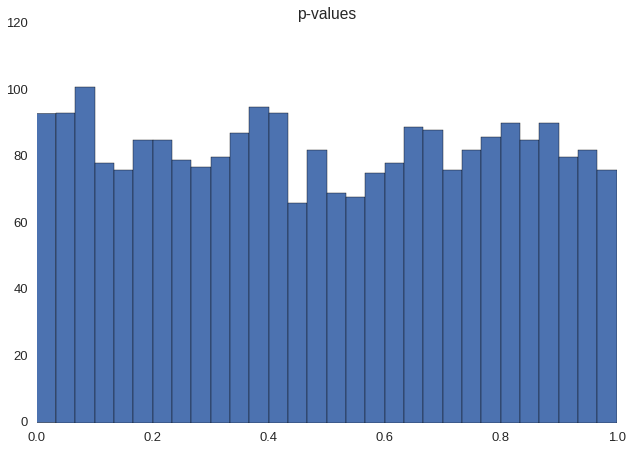

In [63]:
plt.hist(alpha_vals[trait_name].ix['p-value',:], bins=30)
plt.title("p-values")
plt.show()

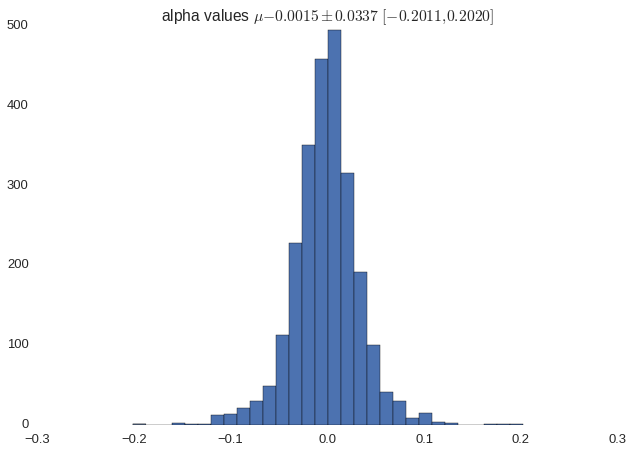

In [64]:
plt.hist(alpha_vals[trait_name].ix['alpha',:], bins=30)
plt.title("alpha values $\mu %.4f \pm %.4f \ [%.4f, %.4f]$" % (np.mean(alpha_vals[trait_name].ix['alpha',:]),
                                                            np.std(alpha_vals[trait_name].ix['alpha',:]),
                                                            np.min(alpha_vals[trait_name].ix['alpha',:]),
                                                             np.max(alpha_vals[trait_name].ix['alpha',:])))
plt.show()

In [66]:
def is_homozygous(gt):
    if len(set([x.strip() for x in gt.split("/")])) == 1:
        return True
    return False

def get_allele_counts(counts):
    a = {}
    het = 0
    for gt in counts.index:
        for allele in [x.strip() for x in gt.split("/")]:
            if not allele in a:
                a[allele] = 0
            a[allele] += counts[gt]
        if not is_homozygous(gt):
            het += counts[gt]
    return sorted(a.items(), key=lambda x: x[1], reverse=True), het

def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def get_allele_freqs(locus):
    locus = locus[locus != '?/?']
    locus = locus[locus != 'NA']
    c = locus.value_counts()
    c = c.sort(inplace=False, ascending=False)
    allele_counts = get_allele_counts(c)
    total_alleles = 2.0*sum(c)
    num_individuals = sum(c)
    A = ""
    a = ""
    P = 0
    Q = 0
    if len(allele_counts[0]) == 2:
        A = allele_counts[0][0][0]
        a = allele_counts[0][1][0]
        P = allele_counts[0][0][1]
        Q = allele_counts[0][1][1]
    else:
        A = allele_counts[0][0][0]
        P = P = allele_counts[0][0][1]
    PQ = allele_counts[-1]
    p = P/total_alleles
    q = Q/total_alleles
    assert p + q == 1.0
    He = 2 * p * q * get_correction(num_individuals)
    Ho = PQ*1.0/num_individuals
    Fis = 1 - (Ho/He)
    #print p, q, He, Ho, Fis
    ret = pd.Series({"p":p, 
                      "q":q,
                      "P":P,
                      "Q":Q,
                      "He":He,
                      "Ho":Ho, 
                      "Fis":Fis,
                    "PQ": PQ,
                    "total_alleles":total_alleles,
                    "num_indiv":num_individuals,
                    "A":A,
                    "a":a})
    return ret

In [73]:
trait_snpassoc_pca_county = pd.concat([trait_complete.countyid, trait_snpassoc_pca], axis=1)


In [76]:
trait_snpassoc_pca_county = trait_snpassoc_pca_county.drop(trait_snpassoc_pca_county[np.isnan(trait_snpassoc_pca_county[trait_name])].index)

In [78]:
snpassoc_af = trait_snpassoc_pca_county.ix[:,2:-14].apply(get_allele_freqs)

In [79]:
snpassoc_af

,0-10037-01-257,0-10040-02-394,0-10044-01-392,0-10048-01-60,0-10051-02-166,0-10054-01-402,0-10067-03-111,0-10079-02-168,0-10112-01-169,0-10113-01-119,0-10116-01-165,0-10151-01-86,0-10162-01-255,0-10207-01-280,0-10210-01-41,...,UMN-CL299Contig1-01-46,UMN-CL306Contig1-04-261,UMN-CL307Contig1-04-143,UMN-CL319Contig1-03-131,UMN-CL326Contig1-05-421,UMN-CL339Contig1-05-39,UMN-CL34Contig1-03-89,UMN-CL353Contig1-04-64,UMN-CL362Contig1-07-133,UMN-CL363Contig1-01-233,UMN-CL379Contig1-12-117,UMN-CL424Contig1-03-94,UMN-CL54Contig1-07-88,UMN-CL91Contig1-02-246,UMN-CL97Contig
A,A,C,C,G,G,A,A,G,A,A,A,A,A,A,A,...,A,T,C,C,G,A,G,A,C,G,A,C,G,C,G
Fis,0.03790158,-0.01800787,0.03905122,0.1123853,0.07030303,0.001200686,-0.03827751,0.01592548,-0.06158833,-0.07300731,0.1143453,0.08119658,0.001719146,0.1537527,0.1143967,...,0.09555371,0.007814833,-0.1143142,0.05193962,0.1273477,0.009049774,-0.03865741,-0.006125574,-0.1328293,0.07723564,-0.00921659,0.03601537,0.0345339,-0.1029759,0.04555035
He,0.4138331,0.4972566,0.4999144,0.4394845,0.1290743,0.5006011,0.07385994,0.09294359,0.1120043,0.4358706,0.0448881,0.1482612,0.1047955,0.4290435,0.1140579,...,0.05056321,0.1940632,0.2963679,0.2628849,0.302699,0.0981527,0.3779142,0.01510504,0.4190812,0.1495905,0.02108229,0.3838553,0.400328,0.2733863,0.3470169
Ho,0.3981481,0.5062112,0.4803922,0.3900929,0.12,0.5,0.07668712,0.09146341,0.1189024,0.4676923,0.03975535,0.1362229,0.1046154,0.3630769,0.1010101,...,0.04573171,0.1925466,0.3302469,0.2492308,0.2641509,0.09726444,0.3925234,0.01519757,0.4747475,0.1380368,0.0212766,0.3700306,0.3865031,0.3015385,0.3312102
P,459,349,319,436,605,330,627,624,617,442,639,594,614,448,558,...,639,574,531,549,518,624,480,653,417,599,651,485,472,544,488
PQ,129,163,147,126,39,162,25,30,39,152,13,44,34,118,30,...,15,62,107,81,84,32,126,5,141,45,7,121,126,98,104
Q,189,295,293,210,45,318,25,32,39,208,15,52,36,202,36,...,17,70,117,101,118,34,162,5,177,53,7,169,180,106,140
a,G,A,G,A,A,G,G,A,C,G,C,T,G,C,G,...,C,A,G,A,A,G,C,G,A,A,G,A,A,A,A
num_indiv,324,322,306,323,325,324,326,328,328,325,327,323,325,325,297,...,328,322,324,325,318,329,321,329,297,326,329,327,326,325,314
p,0.7083333,0.5419255,0.5212418,0.6749226,0.9307692,0.5092593,0.9616564,0.9512195,0.9405488,0.68,0.9770642,0.9195046,0.9446154,0.6892308,0.9393939,...,0.9740854,0.8913043,0.8194444,0.8446154,0.8144654,0.9483283,0.7476636,0.9924012,0.7020202,0.9187117,0.9893617,0.7415902,0.7239264,0.8369231,0.7770701


In [80]:
pop_allele_freqs = {}
for pop,data in trait_snpassoc_pca_county.groupby("countyid"):
    print "getting allele freqs for pop % d" % pop
    pop_allele_freqs[pop] = data.ix[:,2:-14].apply(get_allele_freqs)

getting allele freqs for pop  1
getting allele freqs for pop  2
getting allele freqs for pop  3
getting allele freqs for pop  5
getting allele freqs for pop  6
getting allele freqs for pop  7
getting allele freqs for pop  8
getting allele freqs for pop  9
getting allele freqs for pop  11
getting allele freqs for pop  12
getting allele freqs for pop  13
getting allele freqs for pop  14
getting allele freqs for pop  16
getting allele freqs for pop  17
getting allele freqs for pop  18
getting allele freqs for pop  19
getting allele freqs for pop  20
getting allele freqs for pop  21
getting allele freqs for pop  23
getting allele freqs for pop  24
getting allele freqs for pop  25
getting allele freqs for pop  26
getting allele freqs for pop  27
getting allele freqs for pop  28
getting allele freqs for pop  29
getting allele freqs for pop  30
getting allele freqs for pop  31
getting allele freqs for pop  32
getting allele freqs for pop  33
getting allele freqs for pop  34


In [124]:
def get_usable_counties(county):
    if county.county_state in county_id:
        return True
    return False

data_ai = hdf.get("data_ai")
data_ai['usable'] = data_ai.apply(get_usable_counties, axis=1)
data_ai = data_ai.drop(data_ai[data_ai.usable == False].index)

In [254]:
def write_gwas_data_file(df, pheno, outdir):
    out = "%s_gwas_data_file.txt" % pheno
    out = os.path.join(outdir, out)
    df = df.sort_index()
    df[['A1', 'A2', 'EFF', 'FRQ']].to_csv(out,
                                          header=True, 
                                          index=True,
                                          sep="\t")
    print out
    return out

def write_freqs_file(df, pheno, pop_freqs, outdir):
    out = "%s_freqs_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for pop, data in pop_freqs.items():
            m = data.T.merge(df, how="inner", left_index=True, right_index=True)
            m['population'] = pop
            m.index.name = 'SNP'
            m = m.sort_index()
            o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                             index=True,
                                                             sep="\t"))
def write_match_pop_file(df, pheno, pop_freqs, pop, outdir):
    out = "%s_match_pop_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for key, data in pop_freqs.items():
            if key == pop:
                m = data.T.merge(df, how="inner", left_index=True, right_index=True)
                m['population'] = pop
                m.index.name = 'SNP'
                m = m.sort_index()
                o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                                 index=True,
                                                                 sep="\t"))
                break
                
def write_full_dataset_file(df, pheno, pop_freqs, outdir):
    out = "%s_full_dataset_file.txt" % pheno
    out = os.path.join(outdir, out)
    print out
    with open(out, "w") as o:
        o.write("SNP\tCLST\tA1\tA2\tFRQ\n")
        for pop, data in pop_freqs.items():
            m = data.T.merge(df, how="inner", left_index=True, right_index=True)
            m['population'] = pop
            m.index.name = 'SNP'
            m = m.sort_index()
            o.write(m[['population','A1','A2','p']].to_csv(header=False, 
                                                             index=True,
                                                             sep="\t"))   
def write_env_var_data_file(pheno, pop_freqs, outdir):
    cols = [x for x in data_ai.columns if "AI" in x]
    for c in cols:
        pop_id = 1
        out = "%s_%s_env_var_data_file.txt" % (c, pheno)
        out = os.path.join(outdir, out)
        print out
        with open(out, "w") as o:
            o.write("CLST\tENV\tREG\n")
            for pop, d in data_ai.groupby('county_state'):
                pop = float(county_id[pop])*1.0
                if pop in pop_freqs:
                    o.write("%.1f\t%f\t%.1f\n" % (pop, d[c], pop_id))
                    pop_id += 1

In [299]:
cd "~/ipython/"

/gdc_home4/cfried/ipython


In [324]:
squat_outdir = "squat_cfried" #change for your username
if not os.path.exists(squat_outdir):
    os.mkdir(squat_outdir)

for p in alpha_vals:
    full = alpha_vals[p].T
    full['q-value'] = multipletests(full['p-value'], method="fdr_bh")[1]
    full.index = [x.replace(".", "-") for x in full.index]
    full.index = [x[1:] if x.startswith("X") else x for x in full.index]
    full.index.name = "SNP"
    full.AA = full.AA.apply(lambda x: x[0])
    full.aa = full.aa.apply(lambda x: x[0])
    full = full.rename(columns={'alpha':'EFF',
                                'AA':'A1',
                                'aa':'A2',
                                'p': 'FRQ'})
    candidates = full[full['q-value']<0.05]
    print "chose %d candidates" % len(candidates)
    write_gwas_data_file(candidates, p, squat_outdir)
    write_freqs_file(candidates, p, pop_allele_freqs, squat_outdir)
    write_match_pop_file(full, p, pop_allele_freqs, 2, squat_outdir)
    write_full_dataset_file(full, p, pop_allele_freqs, squat_outdir)
    write_env_var_data_file(p, pop_allele_freqs, squat_outdir)

chose 2 candidates
squat_cfried/melezitose_gwas_data_file.txt
squat_cfried/melezitose_freqs_file.txt
squat_cfried/melezitose_match_pop_file.txt
squat_cfried/melezitose_full_dataset_file.txt
squat_cfried/AI_Q1_melezitose_env_var_data_file.txt
squat_cfried/AI_Q2_melezitose_env_var_data_file.txt
squat_cfried/AI_Q3_melezitose_env_var_data_file.txt
squat_cfried/AI_Q4_melezitose_env_var_data_file.txt


In [320]:
env_squat_files = !find {squat_outdir} | grep {trait_name} | grep env_var | grep AI
print env_squat_files
env_squat_files = [os.path.basename(x) for x in env_squat_files]


['squat_cfried/AI_Q1_melezitose_env_var_data_file.txt', 'squat_cfried/AI_Q2_melezitose_env_var_data_file.txt', 'squat_cfried/AI_Q3_melezitose_env_var_data_file.txt', 'squat_cfried/AI_Q4_melezitose_env_var_data_file.txt']


In [321]:
env_var_file_string = "list(%s)" % ", ".join(["'%s'" % x for x in env_squat_files])

In [322]:
squat_scripts_dir = "/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts"
!rm {squat_outdir}/Scripts && ln -s {squat_scripts_dir} {squat_outdir}/Scripts
def get_squat_vars(pheno):
    d = {"gwas.data.file":"'%s_gwas_data_file.txt'" % pheno,
         "freqs.file":"'%s_freqs_file.txt'" % pheno,
         "env.var.data.files": env_var_file_string,
         "match.pop.file":"'%s_match_pop_file.txt'" % pheno,
         "full.dataset.file":"'%s_full_dataset_file.txt'" % pheno,
         "path":"'%s'" % pheno,
         "match.categories":"c('MAF')",
         "match.bins":"list(seq(0,0.5,0.02), c(2), seq(0,1000,100))",
         "cov.SNPs.per.cycle":5000,
         "cov.cycles":1,
         "null.phenos.per.cycle":1000,
         "null.cycles":1,
         "load.cov.mat":"F",
         "sim.null":"T",
         "check.allele.orientation":"F"}
    return ',\n'.join("%s=%s" % (key,val) for (key,val) in d.items())

def create_squat_run_file(pheno):
    squat_file = os.path.join(squat_outdir, "squat_%s.r" % pheno)
    with open(squat_file, "w") as o:
        o.write('system("rm -rf %s")\n'% pheno)
        o.write("source('%s')\n" % os.path.join(squat_scripts_dir, "CreateTraitFile.R"))
        o.write("source('%s')\n" % os.path.join(squat_scripts_dir, "functions.R"))
        o.write("PolygenicAdaptationFunction(%s)\n" % get_squat_vars(pheno))
    return squat_file

for pheno in alpha_vals:
    squat_file = create_squat_run_file(pheno)
    print squat_file
    !cat $squat_file
    print ""

squat_cfried/squat_melezitose.r
system("rm -rf melezitose")
source('/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts/CreateTraitFile.R')
source('/gdc_home4/cfried/src/PolygenicAdaptationCode/Scripts/functions.R')
PolygenicAdaptationFunction(sim.null=T,
cov.SNPs.per.cycle=5000,
null.cycles=1,
match.bins=list(seq(0,0.5,0.02), c(2), seq(0,1000,100)),
load.cov.mat=F,
path='melezitose',
cov.cycles=1,
match.pop.file='melezitose_match_pop_file.txt',
freqs.file='melezitose_freqs_file.txt',
env.var.data.files=list('AI_Q1_melezitose_env_var_data_file.txt', 'AI_Q2_melezitose_env_var_data_file.txt', 'AI_Q3_melezitose_env_var_data_file.txt', 'AI_Q4_melezitose_env_var_data_file.txt'),
gwas.data.file='melezitose_gwas_data_file.txt',
full.dataset.file='melezitose_full_dataset_file.txt',
match.categories=c('MAF'),
check.allele.orientation=F,
null.phenos.per.cycle=1000)



In [323]:
def run_squat(p):
    print "running %s" % p
    output = "%s/%s" % (squat_outdir, p)
    if os.path.exists(output):
        !rm -rf {output}
    cmds = ["setwd('%s')" % squat_outdir,
            'source("squat_%s.r")' % (p),
            "setwd('../')"]
    for cmd in cmds:
        print cmd
        r(cmd)
    
run_squat(trait_name)

running melezitose
setwd('squat_cfried')
source("squat_melezitose.r")
setwd('../')


In [325]:
rfiles = !find {squat_outdir} | grep Robj | grep Output | grep {trait_name}
bc = {}
for f in rfiles:
    d = f.split("/")
    if not d[1] in bc:
        bc[d[1]] = []
    bc[d[1]].append(f)
bc

{'melezitose': ['squat_cfried/melezitose/Output/genetic.values.Robj',
  'squat_cfried/melezitose/Output/theStats.Robj',
  'squat_cfried/melezitose/Output/asymptotic.pVals.Robj',
  'squat_cfried/melezitose/Output/pVals.Robj',
  'squat_cfried/melezitose/Output/nullStats.Robj']}

In [326]:
for pheno in bc:
    print pheno
    for obj in bc[pheno]:
        r('load("%s")' % obj)
    print r("the.stats")
    print("------------------")
    print r("p.vals")

melezitose
$Qx
[1] 23.99343

$Fst.comp
[1] 31.37303

$LD.component
[1] -7.379601

$betas
$betas[[1]]
[1] -0.001558947

$betas[[2]]
[1] -0.02474625

$betas[[3]]
[1] -0.002661235

$betas[[4]]
[1] -0.004253784


$pearson.rs
$pearson.rs[[1]]
[1] -0.2800495

$pearson.rs[[2]]
[1] -0.2884058

$pearson.rs[[3]]
[1] -0.06345363

$pearson.rs[[4]]
[1] -0.2173006


$spearman.rhos
$spearman.rhos[[1]]
           [,1]
[1,] -0.2098522

$spearman.rhos[[2]]
           [,1]
[1,] -0.3108374

$spearman.rhos[[3]]
            [,1]
[1,] -0.08768473

$spearman.rhos[[4]]
           [,1]
[1,] -0.2285714


$reg.Z
           Env File 1  Env File 2  Env File 3  Env File 4
Region 1  -0.81623269 -0.81623269 -0.81623269 -0.81623269
Region 2  -2.23817714 -2.23817714 -2.23817714 -2.23817714
Region 3   0.92708918  0.92708918  0.92708918  0.92708918
Region 4   0.48331684  0.48331684  0.48331684  0.48331684
Region 5   0.10726352  0.10726352  0.10726352  0.10726352
Region 6   0.36322870  0.36322870  0.36322870  0.36322870
Re